In [125]:
import opendatasets as od
import pandas as pd

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchmetrics

from PIL import Image
import os
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the theme to a dark grid with a specific palette
sns.set_theme(style="darkgrid", palette="pastel")

# Set the context to "talk", which is suitable for presentations
sns.set_context("notebook")

from utils import train_model

# Histological Cancer Detection

In the real-life adventures of data scientists, acquiring and preparing the data can often be the most time-consuming part of a project.  It may not be much different for this project.

In the next section we will:
* download the dataset using `opendatasets` (you'll need a Kaggle account for this step)
* crop the images and save them to our Google Drive so we have persistent storage.

## Section 0 - Preparing the Data

You won't need to run the code in this section more than once.  To understand the data a bit better here is what Kaggle has to say about this data:

"A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable the design of fully-convolutional models that do not use any zero-padding, to ensure consistent behavior when applied to a whole-slide image."

### Downloading to Colab or a Local Computer

Before you can download the data, you'll need a Kaggle account.  You'll also need to login to Kaggle and then visit:

https://www.kaggle.com/c/histopathologic-cancer-detection

Once there, go to the data tab, click the "Download All" button at the lower right, then scroll down and agree to the terms and conditions.  Once you've done this you can use `opendatasets` to download the data locally or to your Colab directory.

For downloading you'll need your Kaggle username and API key.  Learn more here: http://bit.ly/kaggle-creds.  When you run `od.download` you'll be prompted for those credentials. (The download was less than 3 minutes for me.)

In [96]:
dataset_url = 'https://www.kaggle.com/c/histopathologic-cancer-detection'
od.download(dataset_url)

Skipping, found downloaded files in "./histopathologic-cancer-detection" (use force=True to force download)


### Cropping and Saving a Downsampled Set

The instructions here are for use in Colab, but you can skip the Colab bits and change the target directory to a local one.

First, let's look at the data a bit. Since this data comes from a Kaggle competition, we only have labels for the train data.  

In [97]:
labels = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


This is a big dataset for processing in Colab:

In [98]:
print(f'There are {len(labels)} labeled images.')

There are 220025 labeled images.


To make the data easier to use we'll save a subset of 50,000 images to our Google drive (or local directory) and crop them from 96x96 to the "middle" 32x32 along the way.  The sample size you choose here doesn't determine the size of your training, validation, and test sets.  We'll add another sample size parameter in the next section to allow us to subsample from these already cropped images.

In [99]:
use_colab = False
if use_colab:
    from google.colab import drive
    drive.mount('/content/gdrive')
    source_directory = '/content/histopathologic-cancer-detection/'
    target_directory = '/content/gdrive/MyDrive/Colab Notebooks/histo_cropped_data'
else: # assumes you have the data in the same directory as this notebook
    source_directory = './histopathologic-cancer-detection/'
    target_directory = './histo_cropped'

csv_file = 'train_labels.csv'

In [100]:
def process_images(source_dir, csv_file_name, target_dir, sample_size=None, crop_size=32, seed=42):
    # Convert string paths to pathlib Path objects
    source_dir = Path(source_dir)
    target_dir = Path(target_dir)
    images_dir = target_dir / 'images'
    csv_path = source_dir / csv_file_name  # CSV file is in the source directory

    # Create the target directories if they don't exist
    images_dir.mkdir(parents=True, exist_ok=True)

    # Load the CSV file
    df = pd.read_csv(csv_path)

    # Sample a subset of rows randomly if sample_size is specified
    if sample_size is not None:
        df = df.sample(n=sample_size, random_state=seed)
    else:  # Or use the full dataframe
        df = df

    # Define a transform to crop the images to the center 32x32 region
    transform = transforms.Compose([
        transforms.CenterCrop(crop_size),
    ])

    # Loop over the sampled dataframe
    for _, row in df.iterrows():
        img_id = row['id']
        img_path = source_dir / 'train' / f'{img_id}.tif'
        
        if img_path.exists():
            # Load the image
            image = Image.open(img_path)
            
            # Apply the transformation
            cropped_image = transform(image)
            
            # Save the cropped image
            cropped_image.save(images_dir / f'{img_id}.tif')

    # Save the sampled CSV in the target directory
    sampled_csv_path = target_dir / 'sampled_data.csv'
    df.to_csv(sampled_csv_path, index=False)


In [101]:
num_to_sample = 220025
process_images(source_directory, csv_file, target_directory, sample_size=num_to_sample)  # Set sample_size as needed

## Section 1 - Construct the Datasets and Loaders

Once you've run the cells in Section 0 you don't need to run them every time.  However, if you wanted to use more of the original data you could run the cells above and increase `num_to_sample` to a larger number.

First we'll set the paths to our sampled and cropped data:

In [102]:
use_colab = False
if use_colab:
    from google.colab import drive
    drive.mount('/content/gdrive')
    data_directory = '/content/gdrive/MyDrive/Colab Notebooks/histo_cropped_data'
else: # assumes you have the data in the same directory as this notebook
    data_directory = './histo_cropped'

csv_file = 'sampled_data.csv'

### Downsample again and make splits

The following function will load the labels file, sample a specified number of rows, and split the further downsampled dataset into three datasets according to the specified proportions for training, validation, and testing.   It returns three data frames with the file ids and labels.  We'll use those data frames to construct our datasets.

While there are many ways to accomplish this splitting, having the data frames is useful if we want to compute statistics about out data or process it in other ways.

In [103]:
def load_and_split_data(source_dir, csv_file_name, sample_size, proportions, seed=42):
    # Ensure the proportions sum to 1
    if not 0.99 < sum(proportions) < 1.01:
        raise ValueError("Proportions must sum to 1")
    
    # Load the CSV file
    source_dir = Path(source_dir)
    csv_path = source_dir / csv_file_name
    df = pd.read_csv(csv_path)
    
    # Sample the DataFrame
    sampled_df = df.sample(n=sample_size, random_state=seed)
    
    # Split the DataFrame based on the proportions provided
    if len(proportions) == 3:
        # Split into train, validation, and test sets
        prop_train, prop_valid, _ = proportions
        train_df, temp_df = train_test_split(sampled_df, train_size=prop_train, random_state=seed)
        valid_df, test_df = train_test_split(temp_df, train_size=prop_valid / (1 - prop_train), random_state=seed)
        return train_df, valid_df, test_df
    elif len(proportions) == 2:
        # Split into train and test sets (valid set is not created)
        prop_train, _ = proportions
        train_df, test_df = train_test_split(sampled_df, train_size=prop_train, random_state=seed)
        return train_df, test_df
    else:
        raise ValueError("Proportions tuple must have either two or three elements")

In [104]:
# use data_directory and csv_file defined previously
sample_size = 200000
proportions = (0.8, 0.1, 0.1)  # For a three-way split
# proportions = (0.8, 0.2)  # Uncomment for a two-way split
random_seed = 42

train_df, valid_df, test_df = load_and_split_data(data_directory, csv_file, sample_size, proportions, random_seed)
# For a two-way split, use:
# train_df, test_df = load_and_split_data(data_directory, csv_file, sample_size, proportions, random_seed)

### Make a custom dataset class

In [105]:
class CancerDataset(Dataset):
    def __init__(self, source_dir, dataframe, transform=None):
        """
        Args:
            source_dir (string): Directory with all the tiff images.
            dataframe (pandas.DataFrame): DataFrame with 'id' and 'label'.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.source_dir = source_dir
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = f"{self.source_dir}/{self.dataframe.iloc[idx, 0]}.tif"
        image = Image.open(img_name)
        label = np.float32(self.dataframe.iloc[idx, 1])
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

### Choose Transforms

The transforms for the validation and test datasets should just be converting to tensors and normalization.  You can add data augmentation transforms to the the training transforms:

In [106]:
original_mean = [0.5,0.5,0.5]
original_std = [0.5,0.5,0.5]

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(), ## add more if desired
    transforms.Normalize(mean = original_mean, std = original_std)
])    

valid_transform = transforms.Compose([
        transforms.ToTensor(), # Converts to Tensor and scales pixels between 0 and 1
        transforms.Normalize(mean = original_mean, std = original_std)
    ])

test_transform = valid_transform

### Instatiate the Datasets

In [107]:
images_directory = data_directory + '/images'
train_dataset = CancerDataset(images_directory, train_df, train_transform)
valid_dataset = CancerDataset(images_directory, valid_df, valid_transform)
test_dataset = CancerDataset(images_directory, test_df, test_transform)

### Build the Dataloaders

In [108]:
B = 200
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=B, shuffle=False)
test_loader = DataLoader(valid_dataset, batch_size=B, shuffle=False)

### Train the first CNN 

In [109]:
def ConvBlock(in_chan, out_chan, kernel_size = 5, stride = 1, pad = 2, leak_rate=0.1):
    block = nn.Sequential(
        nn.Conv2d( in_chan, out_chan, kernel_size, stride, pad),
        nn.MaxPool2d(2),
        nn.LeakyReLU(leak_rate)
    )
    return block

def ClassificationHead1H(in_chan, hidden_chan, num_outputs, leak_rate=0.1):
    head = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_chan, hidden_chan),
        nn.LeakyReLU(leak_rate),
        nn.Dropout(0.5),
        nn.Linear(hidden_chan, num_outputs)
    )
    return head
            

class FirstCNN(nn.Module):
    '''
    Two convolution layers.  One output class for BCELossWithLogits
    '''
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            ConvBlock(3, 32),
            ConvBlock(32,64),
            ConvBlock(64,128),
            ClassificationHead1H(128*4*4,500,1)
        )

    def forward(self, x):
        return(self.layers(x).squeeze())

In [134]:
model = FirstCNN()
loss_function = nn.BCEWithLogitsLoss()
num_epochs=15

metrics = {'accuracy': torchmetrics.Accuracy(task='binary'),}

firstcnn_results_df = train_model(model, loss_function,
                         epochs = num_epochs,
                         metrics = metrics,
                         train_loader = train_loader,
                         val_loader = valid_loader)

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 15/15, Training 100.00% complete, Validation 100.00% complete lr = 1.000e-03
 Epoch  train_accuracy  train_loss  val_accuracy  val_loss       Time    LR
    11        0.860981    0.327748       0.84750  0.348935 111.853193 0.001
    12        0.863969    0.323240       0.86240  0.329157 112.674242 0.001
    13        0.866750    0.318790       0.85515  0.344051 112.133578 0.001
    14        0.867569    0.315548       0.86265  0.322885 109.536616 0.001
    15        0.868769    0.311795       0.85755  0.332969 106.751987 0.001


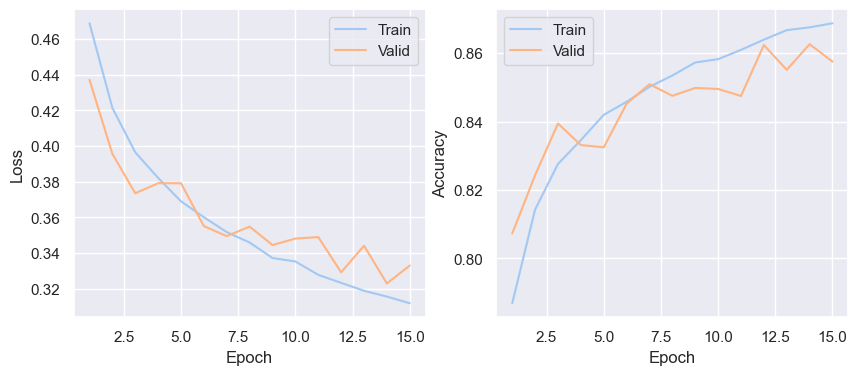

In [135]:
def make_plots(label_df_dict):
    fig,ax = plt.subplots(1,2,figsize=(10,4))
    for label,df in label_df_dict.items():
        sns.lineplot(x='Epoch',y='train_loss',data=df,label='Train',ax=ax[0]);
        sns.lineplot(x='Epoch',y='val_loss',data=df,label='Valid',ax=ax[0]);
        ax[0].set_ylabel('Loss')
    for label,df in label_df_dict.items():    
        sns.lineplot(x='Epoch',y='train_accuracy',data=df,label='Train',ax=ax[1]);
        sns.lineplot(x='Epoch',y='val_accuracy',data=df,label='Valid',ax=ax[1]);
        ax[1].set_ylabel('Accuracy')


results_dict = {'FirstCNN':firstcnn_results_df}
make_plots(results_dict)

In [110]:
# simple Resnet9 https://jovian.ml/aakashns/05b-cifar10-resnet

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class Resnet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [111]:
cnn_resnet9_model = Resnet9(3,1)
loss_function = nn.BCEWithLogitsLoss()
num_epochs=30

metrics = {'accuracy': torchmetrics.Accuracy(task='binary'),}

resnet9_results_df = train_model(model, loss_function,
                         epochs = num_epochs,
                         metrics = metrics,
                         train_loader = train_loader,
                         val_loader = valid_loader)


`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 30/30, Training 100.00% complete, Validation 100.00% complete lr = 1.000e-03
 Epoch  train_accuracy  train_loss  val_accuracy  val_loss       Time    LR
    26        0.892475    0.261513       0.85395  0.368732 119.552297 0.001
    27        0.893456    0.258315       0.84550  0.402293 116.929946 0.001
    28        0.896225    0.251594       0.83650  0.419995 117.544529 0.001
    29        0.896925    0.250986       0.84750  0.387868 123.352345 0.001
    30        0.897913    0.247216       0.84655  0.408112 121.470466 0.001


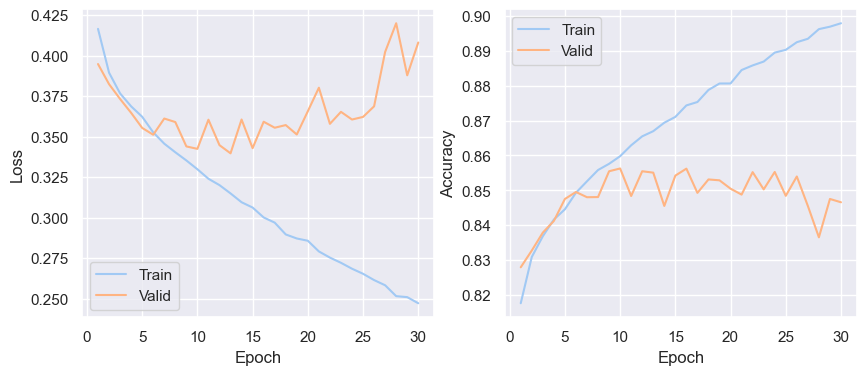

In [133]:
results_dict = {'Resnet9':resnet9_results_df}
make_plots(results_dict)

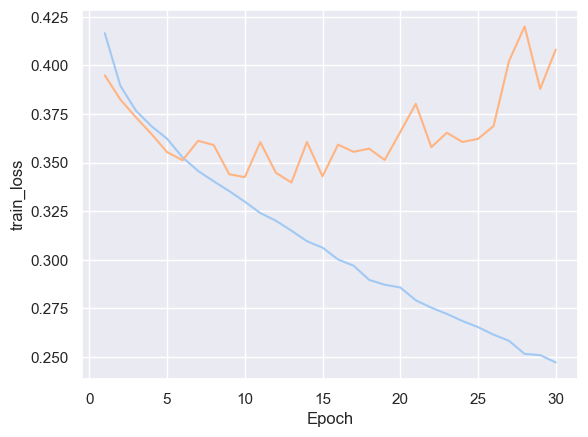

In [128]:
sns.lineplot(x='Epoch',y='train_loss',data=results_df);
sns.lineplot(x='Epoch',y='val_loss',data=results_df);